In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

In [2]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
cdc_diabetes_health_indicators = fetch_ucirepo(id=891) 
  
# data (as pandas dataframes) 
X = cdc_diabetes_health_indicators.data.features 
y = cdc_diabetes_health_indicators.data.targets 
  
# metadata 
print(cdc_diabetes_health_indicators.metadata) 
  
# variable information 
print(cdc_diabetes_health_indicators.variables) 


{'uci_id': 891, 'name': 'CDC Diabetes Health Indicators', 'repository_url': 'https://archive.ics.uci.edu/dataset/891/cdc+diabetes+health+indicators', 'data_url': 'https://archive.ics.uci.edu/static/public/891/data.csv', 'abstract': 'The Diabetes Health Indicators Dataset contains healthcare statistics and lifestyle survey information about people in general along with their diagnosis of diabetes. The 35 features consist of some demographics, lab test results, and answers to survey questions for each patient. The target variable for classification is whether a patient has diabetes, is pre-diabetic, or healthy. ', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Tabular', 'Multivariate'], 'num_instances': 253680, 'num_features': 21, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Sex', 'Age', 'Education Level', 'Income'], 'target_col': ['Diabetes_binary'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_

In [3]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype
---  ------                --------------   -----
 0   HighBP                253680 non-null  int64
 1   HighChol              253680 non-null  int64
 2   CholCheck             253680 non-null  int64
 3   BMI                   253680 non-null  int64
 4   Smoker                253680 non-null  int64
 5   Stroke                253680 non-null  int64
 6   HeartDiseaseorAttack  253680 non-null  int64
 7   PhysActivity          253680 non-null  int64
 8   Fruits                253680 non-null  int64
 9   Veggies               253680 non-null  int64
 10  HvyAlcoholConsump     253680 non-null  int64
 11  AnyHealthcare         253680 non-null  int64
 12  NoDocbcCost           253680 non-null  int64
 13  GenHlth               253680 non-null  int64
 14  MentHlth              253680 non-null  int64
 15  PhysHlth              253680 non-n

In [4]:
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 1 columns):
 #   Column           Non-Null Count   Dtype
---  ------           --------------   -----
 0   Diabetes_binary  253680 non-null  int64
dtypes: int64(1)
memory usage: 1.9 MB


In [5]:
X.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,1,1,1,40,1,0,0,0,0,1,...,1,0,5,18,15,1,0,9,4,3
1,0,0,0,25,1,0,0,1,0,0,...,0,1,3,0,0,0,0,7,6,1
2,1,1,1,28,0,0,0,0,1,0,...,1,1,5,30,30,1,0,9,4,8
3,1,0,1,27,0,0,0,1,1,1,...,1,0,2,0,0,0,0,11,3,6
4,1,1,1,24,0,0,0,1,1,1,...,1,0,2,3,0,0,0,11,5,4


In [6]:
# lower the columns name of X and y
X.columns = X.columns.str.lower()
y.columns = y.columns.str.lower()

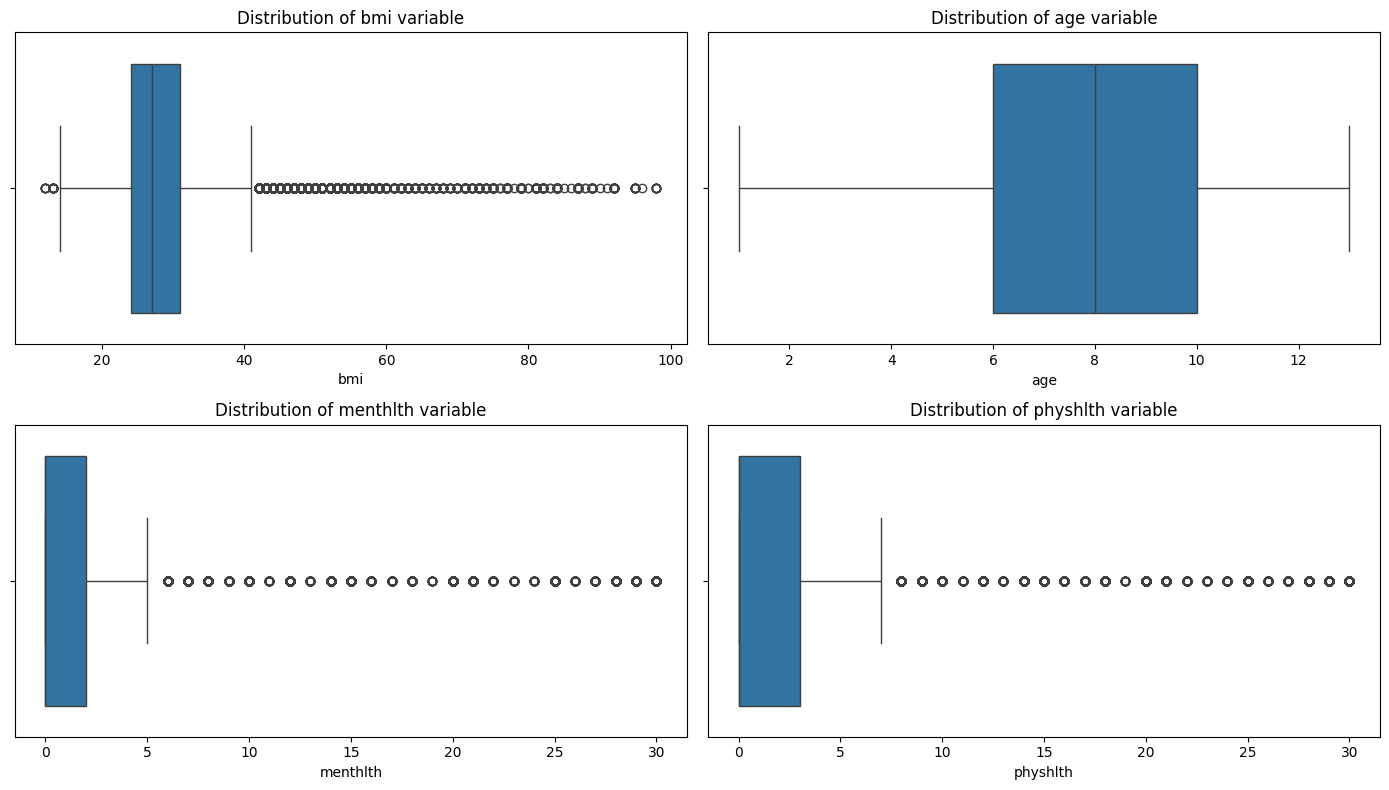

In [7]:
num_var = ['bmi', 'age', 'menthlth', 'physhlth'] 

fig, axes = plt.subplots(2, 2, figsize=(14, 8))

axs = axes.flatten() 

for i, num in enumerate(num_var):
    sns.boxplot(data=X, x=num, ax=axs[i])
    axs[i].set_title(f'Distribution of {num} variable')

plt.tight_layout()
plt.show()

All variables except age have outliers

In [8]:
bin_var = [col for col in X.columns if col not in num_var+['education', 'income', 'genhlth']]

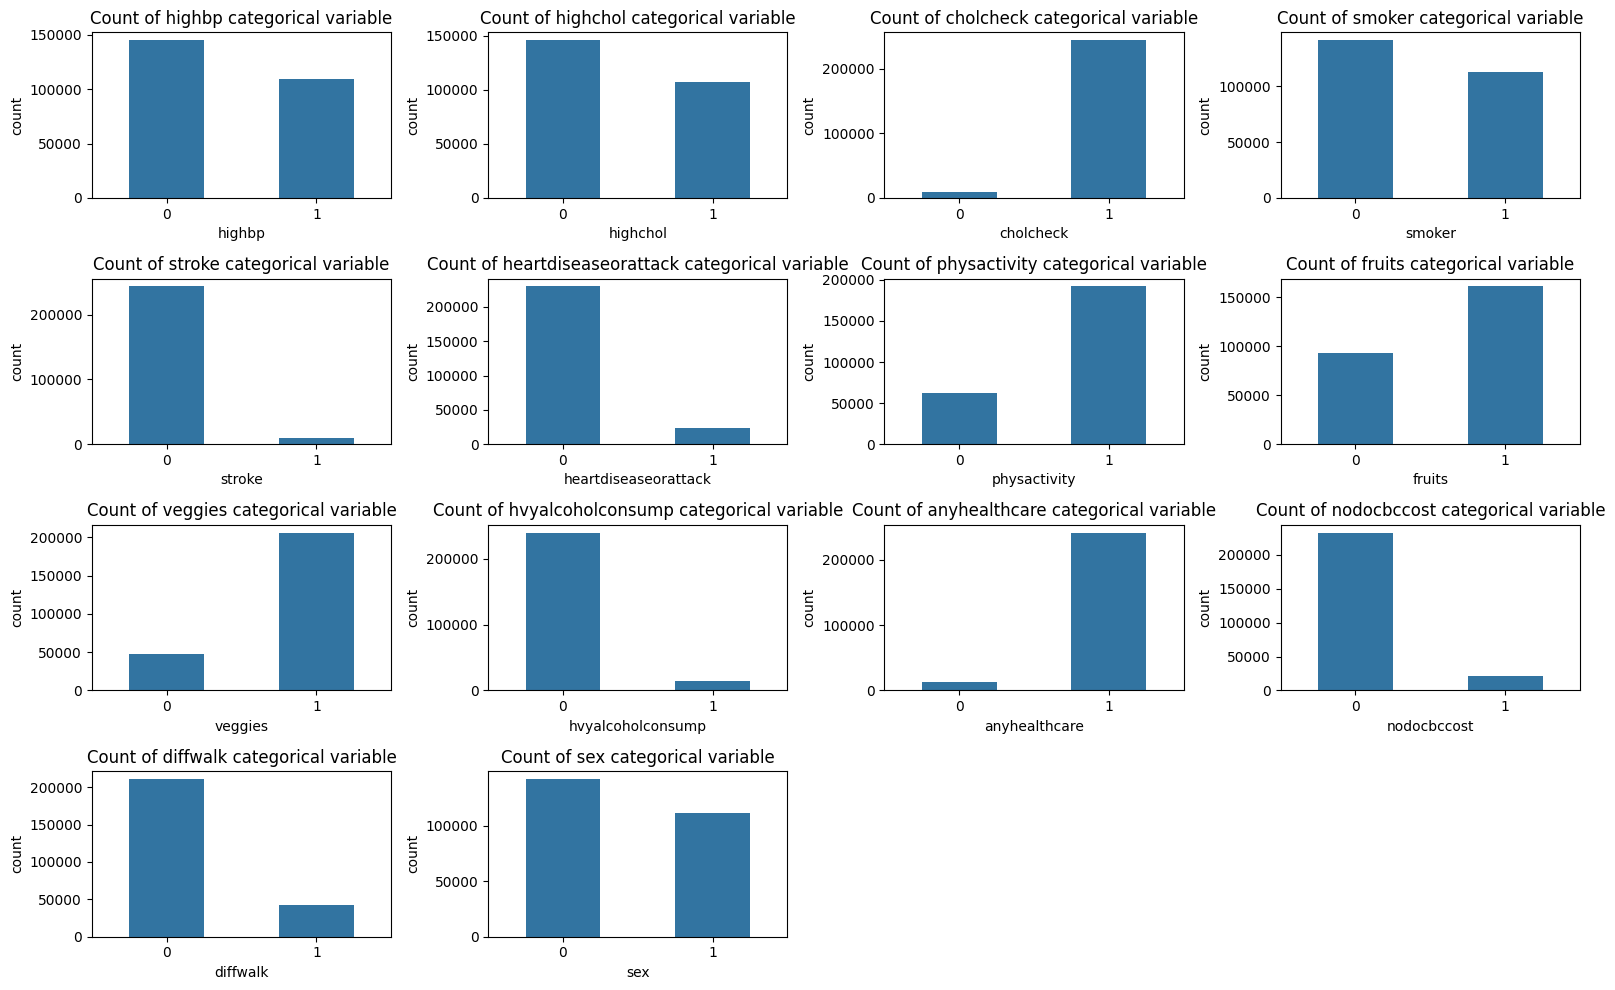

In [9]:
bin_var = [col for col in X.columns if col not in num_var+['education', 'income', 'genhlth']]

fig, axes = plt.subplots(4, 4, figsize=(16, 10))

axs = axes.flatten() 

for i, bin in enumerate(bin_var):
    sns.countplot(data=X, x=bin, ax=axs[i], width=0.5)
    axs[i].set_title(f'Count of {bin} categorical variable')
axs[14].axis('off')
axs[15].axis('off')

plt.tight_layout()
plt.show()

Majority of the variable has significant difference between one class and the other class

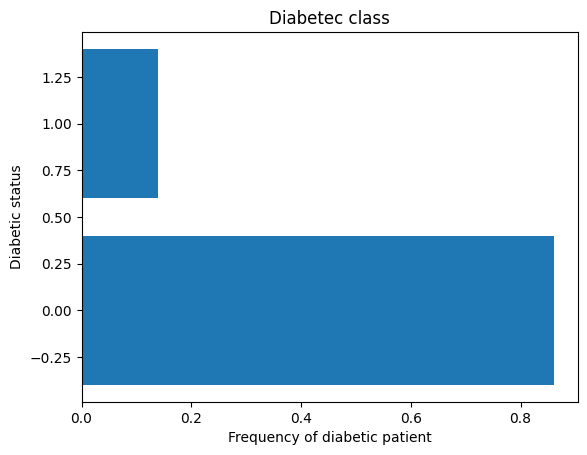

In [10]:
# look at the target variable 
diabetec_count = y.value_counts(normalize=True).reset_index()
diabetec_count.diabetes_binary = diabetec_count.diabetes_binary.astype(str)
plt.barh(diabetec_count.index, diabetec_count.proportion)
plt.title("Diabetec class")
plt.xlabel('Frequency of diabetic patient')
plt.ylabel('Diabetic status')
plt.show()

Patient without diabetic case is higher significantly than patient without diabetic case. This is one case of imbalance

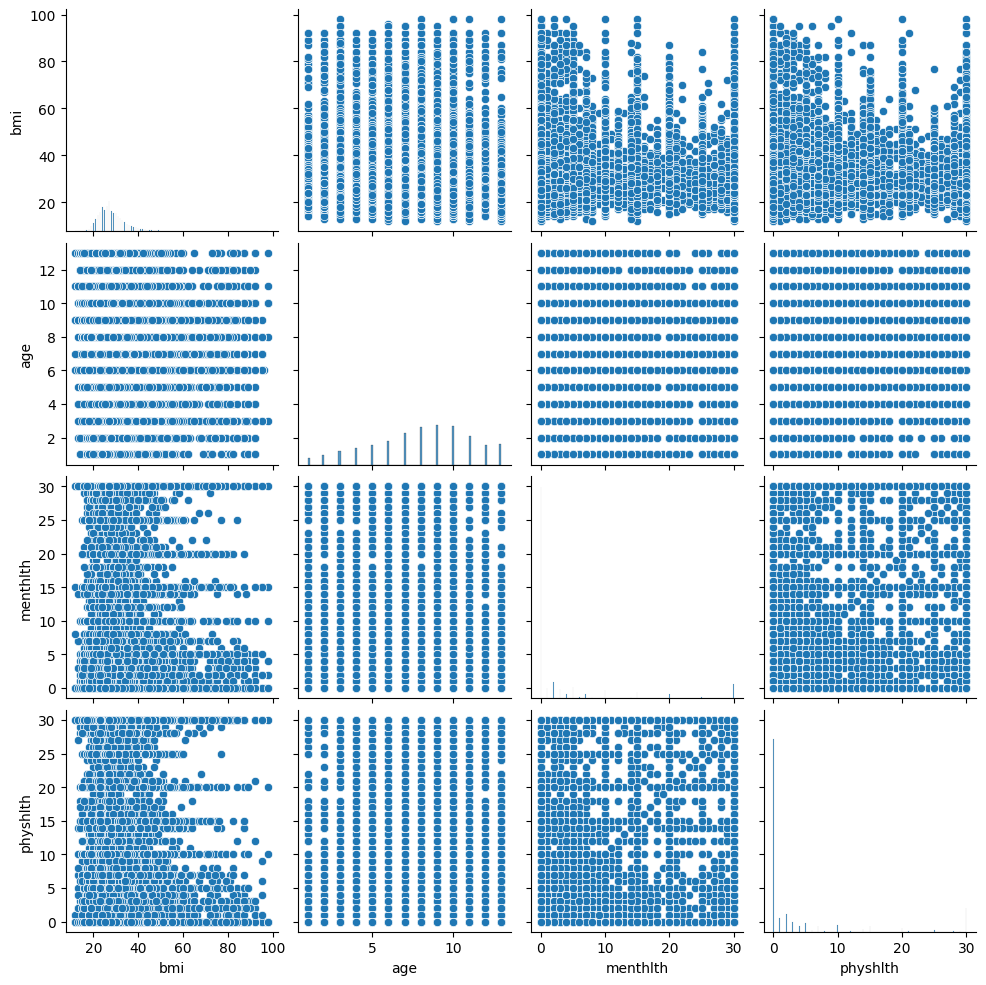

In [11]:
# find the relationship between numeric variable 
sns.pairplot(X[num_var]) 
plt.show()

All of the numeric variables in X have no strong correlation with each other

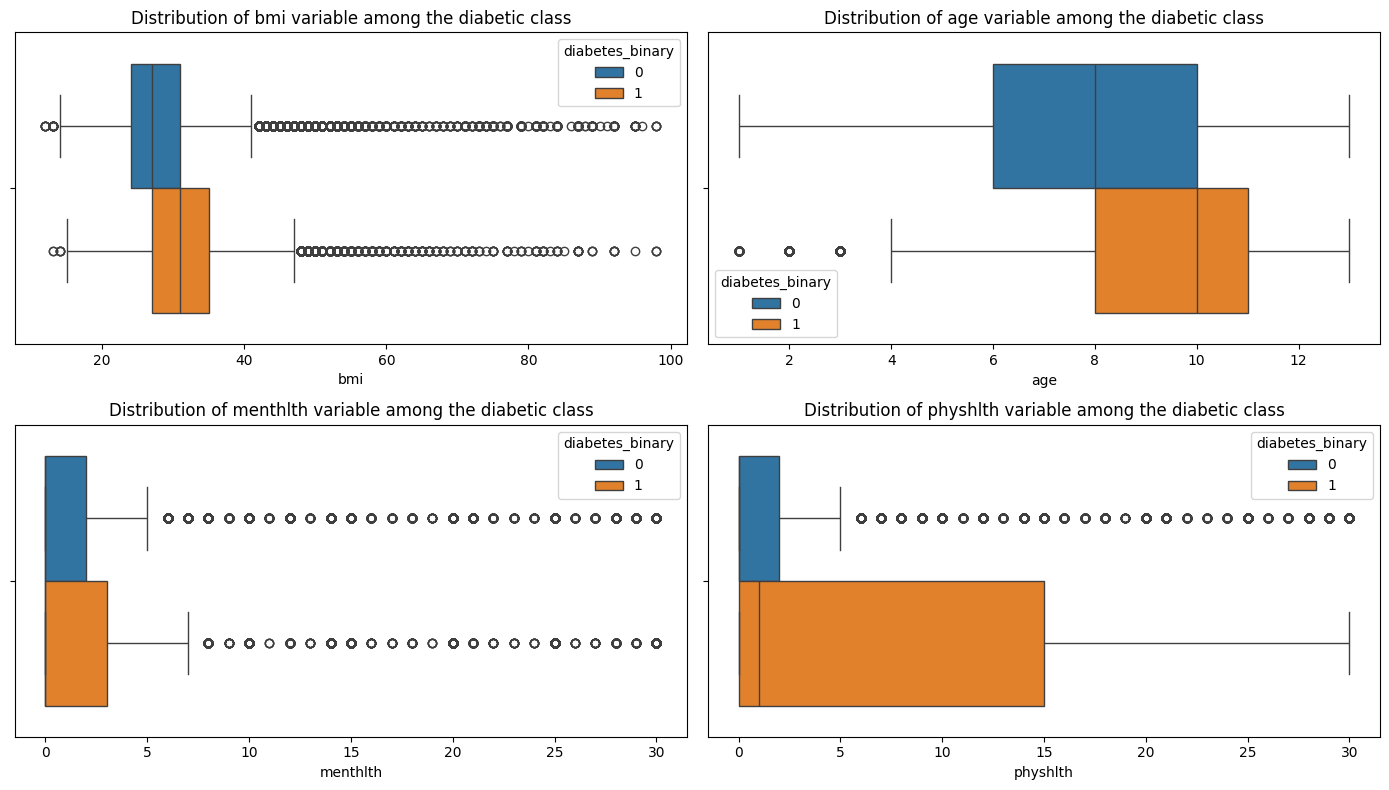

In [13]:
# first combine features with target
full_data = pd.concat([X, y], axis=1)

# distirbution of numeric variable within target 
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

axs = axes.flatten() 

for i, num in enumerate(num_var):
    sns.boxplot(data=full_data, x=num, hue='diabetes_binary', ax=axs[i])
    axs[i].set_title(f'Distribution of {num} variable among the diabetic class')

plt.tight_layout()
plt.show()

For bmi and mental health, the difference of distribution of two classes is not significant
For age and physical health, the difference of distribution of two classes is significant

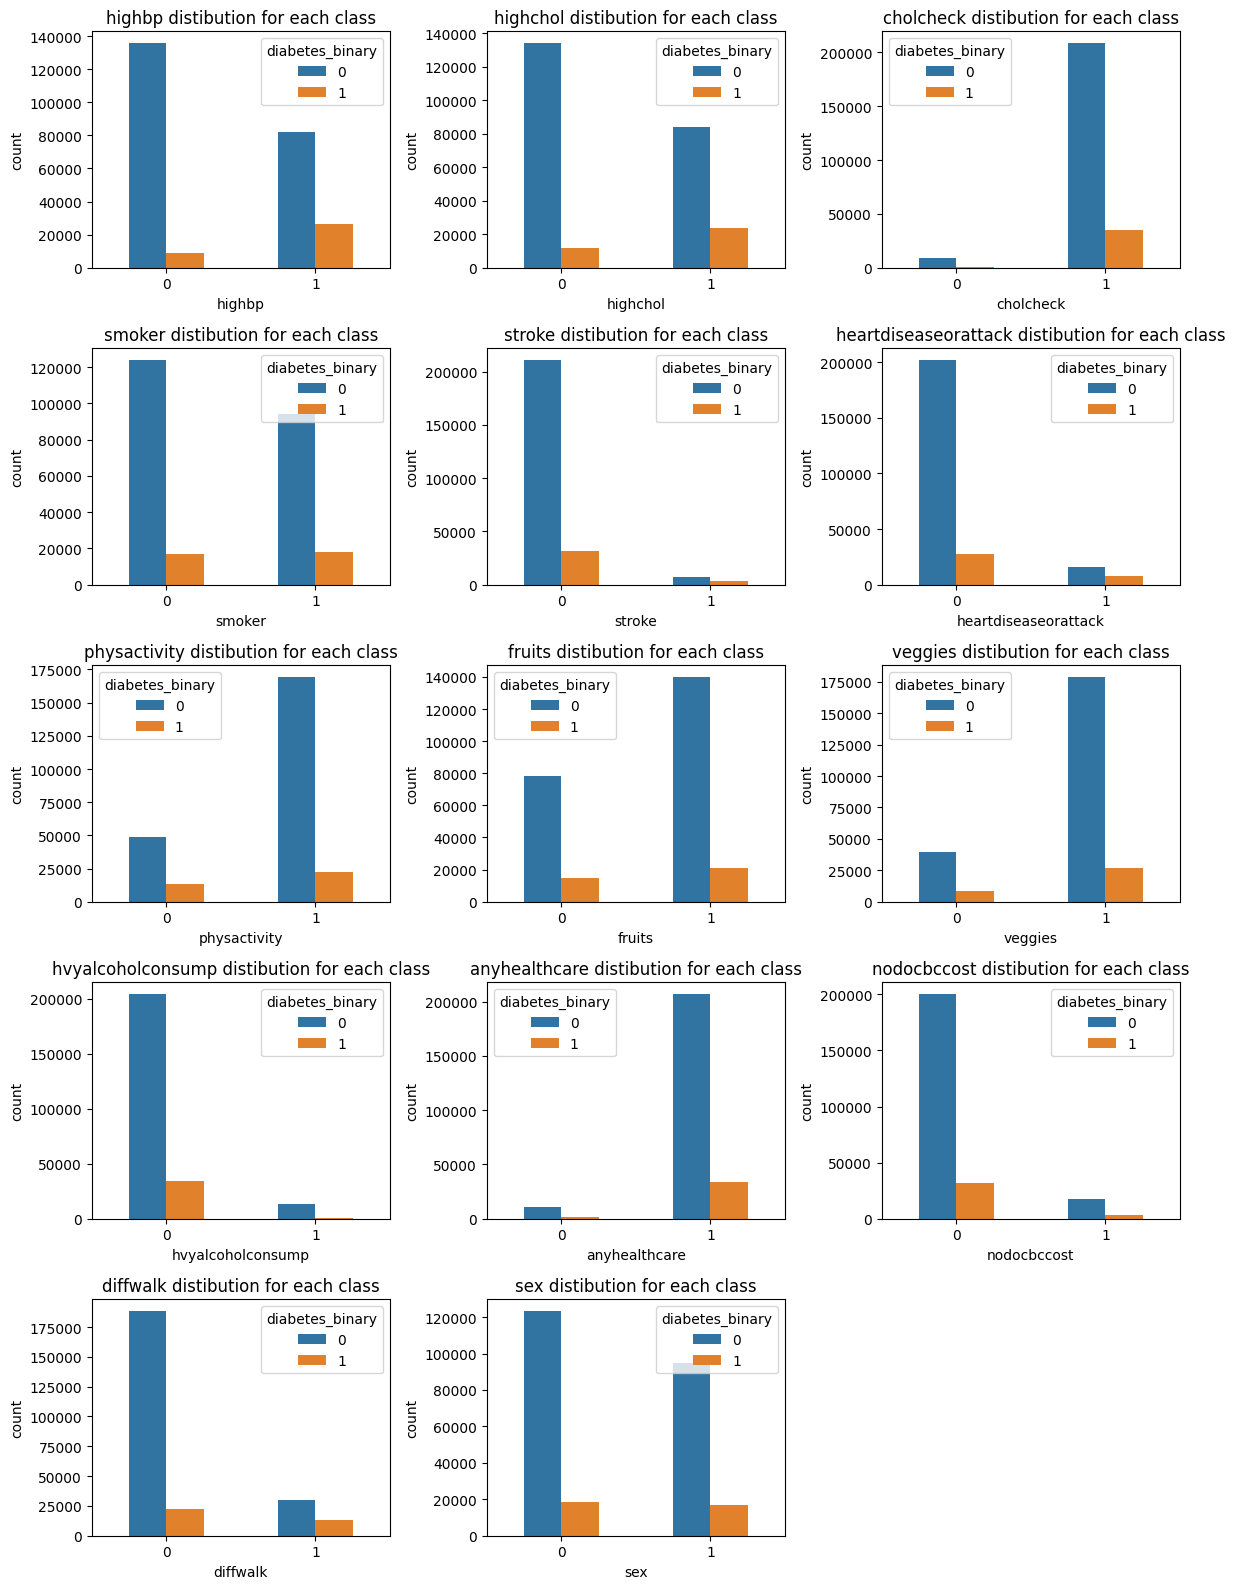

In [19]:
# distirbution of categorical variable within target  
fig, axes = plt.subplots(5, 3, figsize=(12, 16))

axs = axes.flatten() 

for i, bin in enumerate(bin_var):
    sns.countplot(data=full_data, x=bin, hue='diabetes_binary', ax=axs[i], width=0.5)
    axs[i].set_title(f'{bin} distibution for each class')
axs[14].axis('off')
#axs[15].axis('off')

plt.tight_layout()
plt.show()

In all of the categorical variable, the non-diabetic class is significantly higher than diabetic class